In [1]:
# Import-a-thon.

import sqlite3
import pandas as pd
from py2neo import Graph
from igraph import Graph as IGraph
import matplotlib.pyplot as plt
%matplotlib inline

# Randomizer for user and/or product selection.
from random import randint

# Recipe Recommender System

## Agenda

1. Datasets
2. Tech Stack
    - Cleaning and preparing the datasets
    - Any fun EDAs 
3. Overview of Recommender Systems
    - Collaborative-based Filtering
    - Content-based Filtering
    - What did not work aka Lessons learnt the hard way
4. Cross Polination
5. Summary

---

# 1. Datasets

1. Instacart's users and the products they have bought (in the year 2017).
2. Epicurous's recipe dataset (from 2017).

# 2. Tech Stack

List of tools used and their packages:
1. Relational Database, SQL (SQLite)
2. Graph Database, Neo4j (py2neo)
3. iGraph, for clustering (python-igraph)

## Cleaning datasets for the database

### SQL

- Set up SQL.
- Load the CSVs into pandas and have a quick look.

### Instacart

In [2]:
connection = sqlite3.connect('../data/interim/instacart.db.sqlite')

In [3]:
# Load the orders dataset.
orders = '../data/raw/orders.csv'
df_order = pd.read_csv(orders, encoding = 'utf8')

# Save it to SQL.
df_order.to_sql(name='orders',con=connection,if_exists='replace',index=False)

In [4]:
# Load the products dataset.
products = '../data/raw/products.csv'
df_product = pd.read_csv(products, encoding = 'utf8')

# Save it to SQL.
df_product.to_sql(name='product',con=connection,if_exists='replace',index=False)

In [5]:
# Load the order_products dataset.
order_products = '../data/raw/order_products.csv'
df_main = pd.read_csv(order_products, encoding = 'utf8')

# Saving to a SQL file.
df_main.to_sql(name='main',con=connection,if_exists='replace',index=False)

In [6]:
# Load the aisles dataset.
aisles = '../data/raw/aisles.csv'
df_aisle = pd.read_csv(aisles, encoding = 'utf8')

# Saving to a SQL file.
df_aisle.to_sql(name='aisle',con=connection,if_exists='replace',index=False)

In [7]:
# Load the departments dataset.
departments = '../data/raw/departments.csv'
df_department = pd.read_csv(departments, encoding = 'utf8')

# Saving to a SQL file.
df_department.to_sql(name='department',con=connection,if_exists='replace',index=False)

### Preparing the files For Neo4j

- Neo4j reads CSV files and JSON files (via a plugin)
- Doesn't like duplicates. 
- Is quite particular ~~annoying~~ about encoding.
- Doesn't like strings such as: '9" Cast Iron Pot'
- Condense 5 CSV files into 2:
    1. `products_clean.csv`
    2. `users_order.csv`

In [8]:
# Create products_clean.csv.

sql_query = '''
SELECT product.product_id, product.product_name, product.aisle_id, product.department_id, aisle.aisle, department.department
FROM product
INNER JOIN aisle ON product.aisle_id = aisle.aisle_id
INNER JOIN department ON product.department_id = department.department_id
'''

In [9]:
# This will take awhile...
df = pd.read_sql(sql_query, con=connection)
df.head()

,product_id,product_name,aisle_id,department_id,aisle,department
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
1,2,All-Seasons Salt,104,13,spices seasonings,pantry
2,3,Robust Golden Unsweetened Oolong Tea,94,7,tea,beverages
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen meals,frozen
4,5,Green Chile Anytime Sauce,5,13,marinades meat preparation,pantry


In [10]:
df['department'].value_counts()

personal care      6563
snacks             6264
pantry             5371
beverages          4365
frozen             4007
dairy eggs         3449
household          3085
canned goods       2092
dry goods pasta    1858
produce            1684
bakery             1516
deli               1322
missing            1258
international      1139
breakfast          1115
babies             1081
alcohol            1054
pets                972
meat seafood        907
other               548
bulk                 38
Name: department, dtype: int64

In [11]:
to_delete = ['personal care','household','missing','babies','pets']

df_clean = df[~df['department'].isin(to_delete)].copy()
df_clean.head()

,product_id,product_name,aisle_id,department_id,aisle,department
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
1,2,All-Seasons Salt,104,13,spices seasonings,pantry
2,3,Robust Golden Unsweetened Oolong Tea,94,7,tea,beverages
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen meals,frozen
4,5,Green Chile Anytime Sauce,5,13,marinades meat preparation,pantry


In [12]:
# Remove those with " in the names.
df_clean = df_clean[~df_clean['product_name'].str.contains('"')]

In [13]:
# Remove any weird encodings.
df_clean['product_name'] = df_clean['product_name'].apply(lambda x: x.encode('ascii', 'ignore').decode('ascii').strip())

In [14]:
# Save to csv.
df_clean.to_csv('../data/processed/products_clean.csv', index=False)

In [15]:
# Create the users AND orders csv.

sql_query = '''
SELECT orders.user_id, main.product_id, COUNT(orders.order_id) AS count_orders
FROM main
INNER JOIN orders ON orders.order_id = main.order_id
GROUP BY orders.order_id
'''

In [16]:
# This will take awhile...
df = pd.read_sql(sql_query, con=connection)

In [17]:
df.sort_values(by='user_id', inplace=True)
df.head(20)

,user_id,product_id,count_orders
445008,1,30450,5
405352,1,13176,8
2118491,1,26405,5
2396411,1,12427,9
2386095,1,26405,5
2253888,1,13032,6
516695,1,13032,5
3164631,1,25133,4
2156588,1,12427,6
2921151,1,49235,6


In [18]:
df.shape

(3214874, 3)

In [19]:
# Summing the total_orders.
# 'Duplicates' created when users buy one item more than once in the same order.
df['total_orders'] = df.groupby(['user_id', 'product_id'])['count_orders'].transform('sum')

In [20]:
# Drop row duplicates since we have the total_orders.
df.drop_duplicates(subset=['user_id','product_id'], keep='first', inplace=True)

# Drop column 'count_order' since we don't need it anymore.
df.drop(columns=['count_orders'], inplace=True)

df.head(20)

,user_id,product_id,total_orders
445008,1,30450,5
405352,1,13176,8
2118491,1,26405,10
2396411,1,12427,15
2253888,1,13032,11
3164631,1,25133,4
2921151,1,49235,6
3001541,2,34688,14
1317127,2,21227,15
1572067,2,47766,13


In [21]:
# This will take awhile...
df.to_csv('../data/processed/users_orders.csv', index=False)

### Epicurious

Not CSV, but a JSON file!

In [22]:
epi = pd.read_json('../data/raw/full_format_recipes.json', orient='values', encoding='utf-8')
epi.head()

,calories,categories,date,desc,directions,fat,ingredients,protein,rating,sodium,title
0,426.0,"[Sandwich, Bean, Fruit, Tomato, turkey, Vegeta...",2006-09-01 04:00:00,None,"[1. Place the stock, lentils, celery, carrot, ...",7.0,"[4 cups low-sodium vegetable or chicken stock,...",30.0,2.500,559.0,"Lentil, Apple, and Turkey Wrap"
1,403.0,"[Food Processor, Onion, Pork, Bake, Bastille D...",2004-08-20 04:00:00,This uses the same ingredients found in boudin...,[Combine first 9 ingredients in heavy medium s...,23.0,"[1 1/2 cups whipping cream, 2 medium onions, c...",18.0,4.375,1439.0,Boudin Blanc Terrine with Red Onion Confit
2,165.0,"[Soup/Stew, Dairy, Potato, Vegetable, Fennel, ...",2004-08-20 04:00:00,None,[In a large heavy saucepan cook diced fennel a...,7.0,"[1 fennel bulb (sometimes called anise), stalk...",6.0,3.750,165.0,Potato and Fennel Soup Hodge
3,NaN,"[Fish, Olive, Tomato, Sauté, Low Fat, Low Cal,...",2009-03-27 04:00:00,The Sicilian-style tomato sauce has tons of Me...,[Heat oil in heavy large skillet over medium-h...,NaN,"[2 tablespoons extra-virgin olive oil, 1 cup c...",NaN,5.000,NaN,Mahi-Mahi in Tomato Olive Sauce
4,547.0,"[Cheese, Dairy, Pasta, Vegetable, Side, Bake, ...",2004-08-20 04:00:00,None,[Preheat oven to 350°F. Lightly grease 8x8x2-i...,32.0,"[1 12-ounce package frozen spinach soufflé, th...",20.0,3.125,452.0,Spinach Noodle Casserole


In [23]:
epi.drop(columns=['fat','calories','date','protein','sodium','desc'], inplace=True)

In [24]:
epi['categories'][0]

['Sandwich',
 'Bean',
 'Fruit',
 'Tomato',
 'turkey',
 'Vegetable',
 'Kid-Friendly',
 'Apple',
 'Lentil',
 'Lettuce',
 'Cookie']

In [25]:
epi['directions'][0]

['1. Place the stock, lentils, celery, carrot, thyme, and salt in a medium saucepan and bring to a boil. Reduce heat to low and simmer until the lentils are tender, about 30 minutes, depending on the lentils. (If they begin to dry out, add water as needed.) Remove and discard the thyme. Drain and transfer the mixture to a bowl; let cool.',
 '2. Fold in the tomato, apple, lemon juice, and olive oil. Season with the pepper.',
 '3. To assemble a wrap, place 1 lavash sheet on a clean work surface. Spread some of the lentil mixture on the end nearest you, leaving a 1-inch border. Top with several slices of turkey, then some of the lettuce. Roll up the lavash, slice crosswise, and serve. If using tortillas, spread the lentils in the center, top with the turkey and lettuce, and fold up the bottom, left side, and right side before rolling away from you.']

In [26]:
epi['ingredients'][0]

['4 cups low-sodium vegetable or chicken stock',
 '1 cup dried brown lentils',
 '1/2 cup dried French green lentils',
 '2 stalks celery, chopped',
 '1 large carrot, peeled and chopped',
 '1 sprig fresh thyme',
 '1 teaspoon kosher salt',
 '1 medium tomato, cored, seeded, and diced',
 '1 small Fuji apple, cored and diced',
 '1 tablespoon freshly squeezed lemon juice',
 '2 teaspoons extra-virgin olive oil',
 'Freshly ground black pepper to taste',
 '3 sheets whole-wheat lavash, cut in half crosswise, or 6 (12-inch) flour tortillas',
 '3/4 pound turkey breast, thinly sliced',
 '1/2 head Bibb lettuce']

In [27]:
epi['title'][0]

'Lentil, Apple, and Turkey Wrap '

In [28]:
epi['title'] = epi['title'].str.strip()

In [29]:
epi.shape

(20130, 5)

In [30]:
epi.drop_duplicates(subset='title', keep='first', inplace=True)
epi.shape

(17776, 5)

In [31]:
epi.to_json('../data/processed/epi_recipe_json_cleaned.json', force_ascii=False, orient='records')

# After doing this, we still got some encoding errors in Neo4j. 
# Solution: open the file in Notepad++ and 'convert to UTF-8' and save it again. 
# Then it works... I am not sure if this is a Neo4j bug or a pandas to_json write bug, or I didn't do it properly.

#### Any fun EDAs

Average number of purchases across all users.

In [32]:
df.head()

,user_id,product_id,total_orders
445008,1,30450,5
405352,1,13176,8
2118491,1,26405,10
2396411,1,12427,15
2253888,1,13032,11


In [60]:
users_total_purchases = df.groupby(['user_id'])['total_orders'].transform('sum').to_frame(name = 'total_purchases').reset_index()

In [61]:
users_total_purchases.sort_values(by='index', inplace=True)
users_total_purchases.head()

,index,total_purchases
2493775,0,90
2539452,1,323
2200215,2,923
1928606,3,967
275296,4,91


In [62]:
users_total_purchases['total_purchases'].describe()

count    2.542333e+06
mean     3.226870e+02
std      3.172301e+02
min      3.000000e+00
25%      9.500000e+01
50%      2.170000e+02
75%      4.500000e+02
max      3.725000e+03
Name: total_purchases, dtype: float64

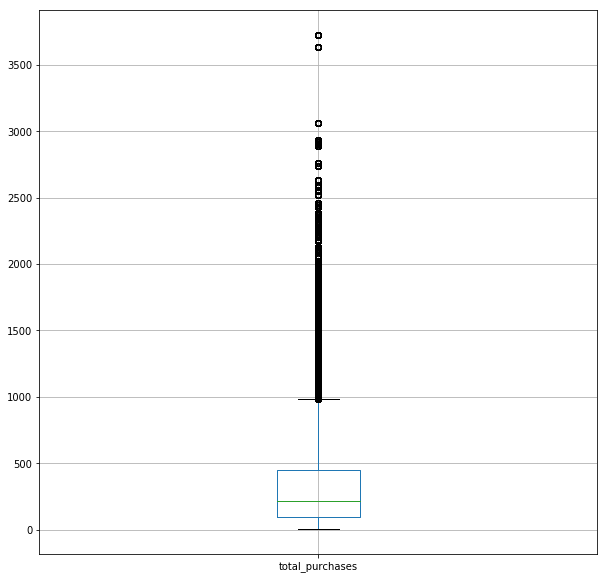

In [63]:
users_total_purchases.boxplot(column='total_purchases',figsize=(10,10))
plt.show()

Products most purchased.

In [35]:
# just an example, replace with credentials for your own Neo4j instance.
graph = Graph(bolt=True, host="localhost", http_port=7687, user='neo4j', password='pasta')

In [36]:
pd.DataFrame(graph.data('''
MATCH (u:User)-[b:BOUGHT]->(p:Product)
RETURN p.name, COUNT(b) AS orders
ORDER BY orders DESC
LIMIT 10
'''))

,orders,p.name
0,17649,Banana
1,17182,Bag of Organic Bananas
2,15740,Organic Strawberries
3,14597,Organic Baby Spinach
4,10660,Strawberries
5,10097,Organic Hass Avocado
6,9088,Large Lemon
7,8573,Organic Blueberries
8,8555,Organic Avocado
9,8198,Limes


# Data Stucture

![](../reports/assets/data_structure.png)

![](../reports/assets/database_schema.png)

# 3. Overview of Recommender Systems

There are three approaches to recommender systems: 
1. Collaborative-based Filtering
2. Content-based Filtering
3. A Hybrid of Both

Similarity metrics:
1. Cosine similarity scores
2. Pearson similarity scores
3. Jaccard similarity scores

## Collaborative-based Filtering

What else do other users buy which is _similar_ to what you have bought?

In [86]:
random_user = randint(0, 206210)
print("The selected user ID is: {}".format(random_user))

The selected user ID is: 105394


In [76]:
pd.DataFrame(graph.data("""
MATCH (user:User {id: {user_id}})-[b1:BOUGHT]->(:Product)<-[b2:BOUGHT]-(otheruser:User)
MATCH (otheruser)-[:BOUGHT]->(rec:Product)
WHERE NOT EXISTS( (user)-[:BOUGHT]->(rec)) AND b2.order_total >= b1.order_total
RETURN rec.name AS recommendation, COUNT(*) AS countUsersWhoAlsoBought
ORDER BY countUsersWhoAlsoBought DESC 
LIMIT 10""", user_id=random_user))

,countUsersWhoAlsoBought,recommendation
0,675,Organic Strawberries
1,660,Organic Baby Spinach
2,606,Banana
3,527,Bag of Organic Bananas
4,449,Large Lemon
5,449,Organic Hass Avocado
6,413,Limes
7,393,Organic Avocado
8,373,Organic Zucchini
9,347,Organic Yellow Onion


### Cosine similarity

In [77]:
pd.DataFrame(graph.data("""
MATCH (p1:User {id: {user_id}})-[x:BOUGHT]->(p:Product)<-[y:BOUGHT]-(p2:User)
WITH COUNT(p) AS numberproducts, SUM(x.order_total * y.order_total) AS xyDotProduct,
SQRT(REDUCE(xDot = 0.0, a IN COLLECT(x.order_total) | xDot + a^2)) AS xLength,
SQRT(REDUCE(yDot = 0.0, b IN COLLECT(y.order_total) | yDot + b^2)) AS yLength,
p1, p2
RETURN p2.id AS otherUserID, xyDotProduct / (xLength * yLength) AS cosim
ORDER BY cosim DESC 
LIMIT 10""", user_id=random_user))

,cosim,otherUserID
0,1.0,147654
1,1.0,46475
2,1.0,136547
3,1.0,73551
4,1.0,48514
5,1.0,165319
6,1.0,73540
7,1.0,122798
8,1.0,105576
9,1.0,123889


### Pearson similarity

This is particularly well-suited for product recommendations because it takes into account the fact that different users will have different mean total orders: on average some people do buy only from Instacart, while some prefer to go out of their house. Since Pearson similarity considers differences about the mean, this metric will account for these discrepancies.

In [78]:
pd.DataFrame(graph.data("""
MATCH (u1:User {id: {user_id}})-[r:BOUGHT]->(m:Product)
WITH u1, avg(r.order_total) AS u1_mean

MATCH (u1)-[r1:BOUGHT]->(m:Product)<-[r2:BOUGHT]-(u2)
WITH u1, u1_mean, u2, COLLECT({r1: r1, r2: r2}) AS totalorders WHERE size(totalorders) > 1

MATCH (u2)-[r:BOUGHT]->(m:Product)
WITH u1, u1_mean, u2, avg(r.order_total) AS u2_mean, totalorders

UNWIND totalorders AS r

WITH sum( (r.r1.order_total - u1_mean) * (r.r2.order_total - u2_mean) ) AS nom,
     sqrt( sum( (r.r1.order_total - u1_mean)^2) * sum( (r.r2.order_total - u2_mean) ^2)) AS denom,
     u1, u2 WHERE denom <> 0

RETURN u2.id AS otherUserID, nom/denom AS pearson
ORDER BY pearson DESC 
LIMIT 10""", user_id=random_user))

,otherUserID,pearson
0,89639,0.999991
1,65438,0.999949
2,44149,0.999480
3,83069,0.998148
4,200964,0.996778
5,45284,0.995222
6,59138,0.993740
7,142932,0.990725
8,34466,0.989993
9,184766,0.988878


### Working algorithm for collaborative-based recommendations

Pearson Similiarty and KNN

In [87]:
pd.DataFrame(graph.data("""
MATCH (u1:User {id: {user_id}})-[r:BOUGHT]->(m:Product)
WITH u1, avg(r.order_total) AS u1_mean

MATCH (u1)-[r1:BOUGHT]->(m:Product)<-[r2:BOUGHT]-(u2)
WITH u1, u1_mean, u2, COLLECT({r1: r1, r2: r2}) AS totalorders WHERE size(totalorders) > 2

MATCH (u2)-[r:BOUGHT]->(m:Product)
WITH u1, u1_mean, u2, avg(r.order_total) AS u2_mean, totalorders

UNWIND totalorders AS r

WITH sum( (r.r1.order_total - u1_mean) * (r.r2.order_total - u2_mean) ) AS nom,
     sqrt( sum( (r.r1.order_total - u1_mean)^2) * sum( (r.r2.order_total - u2_mean) ^2)) AS denom,
     u1, u2 WHERE denom <> 0

WITH u1, u2, nom/denom AS pearson
ORDER BY pearson DESC LIMIT 10

MATCH (u2)-[r:BOUGHT]->(m:Product) WHERE NOT EXISTS( (u1)-[:BOUGHT]->(m) )

RETURN m.name AS recommendation, SUM(pearson * r.order_total) AS score
ORDER BY score DESC 
LIMIT 10""", user_id=random_user))

,recommendation,score
0,Organic Small Curd Cottage Cheese,101.894403
1,Organic Salted Butter,59.748594
2,Lime Sparkling Water,38.143570
3,Honey Wheat Enriched Bread,36.236391
4,Organic Mini Sandwich Crackers Peanut Butter,32.751773
5,Limes,30.022458
6,Sweet Onion,28.202915
7,Brussels Sprouts,27.293144
8,Butter Buns Hotdog,25.746910
9,Roasted Turkey,25.746910


## Clustering

Deep in the world of Graph Theory, there's `python-igraph` which is a network analysis package. [Github](https://github.com/igraph/python-igraph).

Community detection with the Walktrap algorithm, based on work by [Pons and Latapy](https://arxiv.org/abs/physics/0512106), _"Computing communities in large networks using random walks"_ (2005). For an overview of Community detection with other algorithms (besides Walktrap), see Yang et. al. _"A Comparative Analysis of Community Detection Algorithms on Artificial Networks"_ (2016) [here](https://www.nature.com/articles/srep30750).

The basic idea of the algorithm is that short random walks tend to stay in the same community. 

It utilizes a graph network to find communities (in this case, patterns of Aisles and Deparments) and 'cluster' them together. 

Find all pairs of aisles and departments. Find how many times they appear together. We'll use this as weight to build a "virtual graph" of the form (Aisle)-[:OCCURS_WITH {weight}]-(Department).

In [88]:
pd.DataFrame(graph.data("""
MATCH (a:Aisle)<-[:FOUND_IN]-()-[:TYPE_OF]->(d:Department)
RETURN a.name AS aisleName, d.name AS departmentName, COUNT(*) AS weight
ORDER BY weight DESC
LIMIT 10"""))

,aisleName,departmentName,weight
0,candy chocolate,snacks,1245
1,ice cream ice,frozen,1089
2,yogurt,dairy eggs,1026
3,chips pretzels,snacks,986
4,tea,beverages,891
5,packaged cheese,dairy eggs,891
6,frozen meals,frozen,880
7,cookies cakes,snacks,874
8,energy granola bars,snacks,832
9,spices seasonings,pantry,797


In [89]:
cluster = graph.run("""
MATCH (a:Aisle)<-[:FOUND_IN]-()-[:TYPE_OF]->(d:Department)
RETURN a.name AS aisleName, d.name AS departmentName, COUNT(*) AS weight""")

In [90]:
ig = IGraph.TupleList(cluster, weights=True)
ig

In [91]:
clusters = IGraph.community_walktrap(ig, weights='weight')
clusters = clusters.as_clustering()
len(clusters)

16

In [92]:
# Let's take a look at the 'clusters'
nodes = [node['name'] for node in ig.vs]
nodes = [{'id': x, 'label': x} for x in nodes]
nodes[:5]

for node in nodes:
    idx = ig.vs.find(name=node['id']).index
    node['group'] = clusters.membership[idx]
    
nodes[:20]

[{'group': 0,
  'id': 'canned fruit applesauce',
  'label': 'canned fruit applesauce'},
 {'group': 0, 'id': 'canned goods', 'label': 'canned goods'},
 {'group': 1, 'id': 'trail mix snack mix', 'label': 'trail mix snack mix'},
 {'group': 1, 'id': 'snacks', 'label': 'snacks'},
 {'group': 1, 'id': 'chips pretzels', 'label': 'chips pretzels'},
 {'group': 2, 'id': 'fresh herbs', 'label': 'fresh herbs'},
 {'group': 2, 'id': 'produce', 'label': 'produce'},
 {'group': 3, 'id': 'prepared soups salads', 'label': 'prepared soups salads'},
 {'group': 3, 'id': 'deli', 'label': 'deli'},
 {'group': 4,
  'id': 'preserved dips spreads',
  'label': 'preserved dips spreads'},
 {'group': 4, 'id': 'pantry', 'label': 'pantry'},
 {'group': 5,
  'id': 'specialty wines champagnes',
  'label': 'specialty wines champagnes'},
 {'group': 5, 'id': 'alcohol', 'label': 'alcohol'},
 {'group': 6, 'id': 'eggs', 'label': 'eggs'},
 {'group': 6, 'id': 'dairy eggs', 'label': 'dairy eggs'},
 {'group': 7, 'id': 'frozen desser

In [93]:
# # Write it back into the database
# #
# # Writing Aisle first

# graph.run('''
# UNWIND {params} AS p 
# MATCH (a:Aisle {name: p.id})
# MERGE (cluster:Cluster {name: p.group})
# MERGE (a)-[:IN_CLUSTER]->(cluster)
# ''', params = nodes)

In [94]:
# # Write it back into the database
# #
# # Writing Department next

# graph.run('''
# UNWIND {params} AS p 
# MATCH (d:Department {name: p.id})
# MERGE (cluster:Cluster {name: p.group})
# MERGE (d)-[:IN_CLUSTER]->(cluster)
# ''', params = nodes)

![](../reports/assets/database_schema_with_closeup.png)

![](../reports/assets/example_cluster07.png)

### Novelty Recommendation

New but not foreign.

We want to recommend a product that is new but not entirely different from what the person has bought before. 

In [95]:
# Find all items bought by a user; Of all the items bought, count the number of aisles; 
# Find the clusters that appears most often.

pd.DataFrame(graph.data("""
MATCH (user:User {id: {user_id}})-[:BOUGHT]->(product)-[:FOUND_IN]->(a:Aisle)-[:IN_CLUSTER]->(cluster)
RETURN cluster.name, COUNT(*) AS times
ORDER BY times DESC
LIMIT 10""", user_id=random_user))

,cluster.name,times
0,2,3
1,4,1
2,6,1
3,0,1


In [96]:
# In the top cluster, find me all the other aisles within that same cluster.
# Order the table by the number of Products found in that Aisle.

pd.DataFrame(graph.data("""
MATCH (user:User {id: {user_id}})-[:BOUGHT]->(product)-[:FOUND_IN]->(a:Aisle)-[:IN_CLUSTER]->(cluster)
WITH user, cluster, COUNT(*) AS times
ORDER BY times DESC
LIMIT 1
WITH cluster
MATCH (cluster)<-[:IN_CLUSTER]-(a)<-[:FOUND_IN]-(p)
WITH cluster, a.name AS aisleName, COUNT(p) as numberOfProducts
RETURN aisleName, numberOfProducts
ORDER BY numberOfProducts DESC
LIMIT 5""", user_id=random_user))

,aisleName,numberOfProducts
0,packaged vegetables fruits,615
1,fresh vegetables,569
2,fresh fruits,382
3,fresh herbs,86
4,packaged produce,32


In [97]:
# In the bottom cluster, find me all the other aisles within that same cluster.
# Order the table by the number of Products found in that Aisle.

pd.DataFrame(graph.data("""
MATCH (user:User {id: {user_id}})-[:BOUGHT]->(product)-[:FOUND_IN]->(a:Aisle)-[:IN_CLUSTER]->(cluster)
WITH user, cluster, COUNT(*) AS times
ORDER BY times ASC
LIMIT 1
WITH cluster
MATCH (cluster)<-[:IN_CLUSTER]-(a)<-[:FOUND_IN]-(p)
WITH cluster, a.name AS aisleName, COUNT(p) as numberOfProducts
RETURN aisleName, numberOfProducts
ORDER BY numberOfProducts DESC
LIMIT 5""", user_id=random_user))

,aisleName,numberOfProducts
0,spices seasonings,797
1,baking ingredients,620
2,salad dressing toppings,560
3,spreads,493
4,condiments,466


In [98]:
# Great. Now, from the bottom cluster, recommend me products that OTHER users have bought a lot of times.

pd.DataFrame(graph.data("""
MATCH (user:User {id: {user_id}})-[:BOUGHT]->(product)-[:FOUND_IN]->(a:Aisle)-[:IN_CLUSTER]->(cluster)
WITH user, cluster, COUNT(*) AS times
ORDER BY times ASC
LIMIT 1
WITH cluster
MATCH (cluster)<-[:IN_CLUSTER]-(a)<-[:FOUND_IN]-(p)
WITH cluster, a.name AS aisleName, COUNT(p) as numberOfProducts
ORDER BY numberOfProducts DESC
LIMIT 1
WITH aisleName AS x
MATCH (Aisle {name: x})<-[:FOUND_IN]-(otherProducts)<-[b:BOUGHT]-()
WHERE b.order_total > 10
RETURN DISTINCT otherProducts.name AS recommendation, MAX(b.order_total) AS maxOrders
ORDER BY maxOrders DESC
LIMIT 10""", user_id=random_user))

,maxOrders,recommendation
0,93,Sea Salt Flakes Original
1,88,Organic Ground Korintje Cinnamon
2,87,Coarse Kosher Salt
3,83,Organic Garlic Powder
4,80,Crushed Red Pepper
5,77,Vegetarian Chili Seasoning
6,72,Organic Ground Black Pepper
7,71,Curry Powder
8,69,Ground Ginger
9,69,Salt


## Content-based Filtering

Content-based filtering didn't work for the groceries dataset. This is because content-based filtering relies on a product to be part of multiple categories. For example:

- Movie A -> Crime, Thriller, Adventure, Drama
- Movie B -> Crime, Drama, Romance

But in the case of groceries, a meat is meat, a vegetable is a vegetable. Frozen vegetables were categorized as "Frozen" food not "Vegetable" AND "Frozen".

But for the recipes dataset, it does work.

In [99]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)

In [100]:
# Recommend recipes most similar to 'Potato and Fennel Soup Hodge'.

pd.DataFrame(graph.data("""
MATCH (m:Recipe)-[:TAGGED_AS]->(g:Category)<-[:TAGGED_AS]-(rec:Recipe)
WHERE m.name = 'Potato and Fennel Soup Hodge'
WITH rec, COLLECT(g.name) AS categories, COUNT(*) AS commonCategories
RETURN rec.name AS recommendation, categories, commonCategories
ORDER BY commonCategories DESC 
LIMIT 10"""))

,categories,commonCategories,recommendation
0,"[Dairy, Potato, Soup/Stew, Vegetable, Fennel]",5,Fresh Fennel Vichyssoise
1,"[Dairy, Potato, Soup/Stew, Gourmet, Vegetable]",5,Salmon Chowder
2,"[Dairy, Soup/Stew, Gourmet, Vegetable, Fennel]",5,"Carrot, Fennel, and Orange Soup"
3,"[Dairy, Soup/Stew, Gourmet, Vegetable]",4,Chilled Minted Zucchini Soup
4,"[Dairy, Soup/Stew, Gourmet, Vegetable]",4,Lobster Bisque
5,"[Soup/Stew, Gourmet, New York, Fennel]",4,Bouillabaisse Linder
6,"[Potato, Gourmet, Vegetable, Fennel]",4,Steamed Vegetables with Basil Pecan Pesto
7,"[Potato, Soup/Stew, Gourmet, Vegetable]",4,Borscht
8,"[Potato, Soup/Stew, Gourmet, Vegetable]",4,White Bean and Vegetable Soup
9,"[Dairy, Potato, Soup/Stew, Vegetable]",4,Roasted Beet Soup with Potato and Dill Salad


### Jaccard similarity

The Jaccard index is a number between 0 and 1 that indicates how similar two sets are. The Jaccard index of two identical sets is 1. If two sets do not have a common element, then the Jaccard index is 0. 

We can calculate the Jaccard index for by comparing the number of categories that each recipe overlaps on.

In [101]:
# Add one extra layer to the recommendation besides using the Jaccard: the Recommended recipes' rating cannot be
# lower than the original recipe that we searched for.

pd.DataFrame(graph.data("""
MATCH (r:Recipe {name: "Spicy Noodle Soup"})-[:TAGGED_AS]->(c:Category)<-[:TAGGED_AS]-(other:Recipe)
WITH r, other, COUNT(c) AS intersection, COLLECT(c.name) AS i

MATCH (r)-[:TAGGED_AS]->(rc:Category)
WITH r, other, intersection, i, COLLECT(rc.name) AS s1

MATCH (other)-[:TAGGED_AS]->(oc:Category)
WITH r, other, intersection, i,  s1, COLLECT(oc.name) AS s2

WITH r, other, intersection, s1, s2

WITH r, other, intersection, s1+filter(x IN s2 WHERE NOT x IN s1) AS union, s1, s2

WHERE other.rating >= r.rating

RETURN other.name AS recommendation, s1,s2,((1.0*intersection)/SIZE(union)) AS jaccard 
ORDER BY jaccard DESC 
LIMIT 5"""))

,jaccard,recommendation,s1,s2
0,0.333333,Hainanese Chicken Rice,"[Coconut, Breakfast, Pepper, Ginger, Gourmet, Lemongrass, Spring, Shrimp, Peanut Free, Dairy Free, Chicken, Garlic, Soup/Stew]","[Gourmet, Rice, Hot Pepper, Garlic, Ginger, Soup/Stew, Chicken]"
1,0.300000,Aromatic Shrimp And Noodle Medicine Soup,"[Coconut, Breakfast, Pepper, Ginger, Gourmet, Lemongrass, Spring, Shrimp, Peanut Free, Dairy Free, Chicken, Garlic, Soup/Stew]","[Bon App�tit, Shrimp, Noodle, Soup/Stew, Lemongrass, Dinner, Healthy, Green Onion/Scallion, Ginger, Peanut Free, Soy Free, Winter, Dairy Free]"
2,0.294118,Coconut Sauce,"[Coconut, Breakfast, Pepper, Ginger, Gourmet, Lemongrass, Spring, Shrimp, Peanut Free, Dairy Free, Chicken, Garlic, Soup/Stew]","[Coconut, Quick & Easy, Herb, Ginger, Gourmet, Lemongrass, Sauce, Blender, Chicken]"
3,0.291667,Thai Shrimp Soup with Lemon and Jalapenos,"[Coconut, Breakfast, Pepper, Ginger, Gourmet, Lemongrass, Spring, Shrimp, Peanut Free, Dairy Free, Chicken, Garlic, Soup/Stew]","[Dairy Free, Sugar Conscious, Tree Nut Free, Peanut Free, No Sugar Added, Soy Free, Lemon, Coconut, Shellfish, Lunch, Jalape�o, Bon App�tit, Shrimp, Healthy, Ginger, Pork, Soup/Stew, Chicken]"
4,0.285714,Coconut Shrimp with Tamarind Ginger Sauce,"[Coconut, Breakfast, Pepper, Ginger, Gourmet, Lemongrass, Spring, Shrimp, Peanut Free, Dairy Free, Chicken, Garlic, Soup/Stew]","[Ginger, Pescatarian, Dairy Free, Peanut Free, Tree Nut Free, Soy Free, Appetizer, Fry, Cocktail Party, Coconut, Shrimp, Summer, Tamarind, Gourmet]"


# 4. Cross Polination

Making the leap from Product to Recipes.

In [102]:
product_name = "Organic Large Extra Fancy Fuji Apple"
words = product_name.split()
words

['Organic', 'Large', 'Extra', 'Fancy', 'Fuji', 'Apple']

In [103]:
pd.DataFrame(graph.data("""
MATCH (c:Category)<-[:TAGGED_AS]-(r:Recipe)-[:TAGGED_AS]->(other:Category)
WHERE c.name IN ['Organic', 'Large', 'Extra', 'Fancy', 'Fuji', 'Apple'] AND r.rating >= 4.5
WITH r, COLLECT(other.name) AS categories, COUNT(*) AS commonCategories
RETURN r.name AS recommendation, categories, commonCategories
ORDER BY commonCategories DESC 
LIMIT 10"""))

,categories,commonCategories,recommendation
0,"[Breakfast, Pepper, Dessert, Brunch, Fruit Juice, Sauce, Vegan, Vegetarian, Fat Free, Kidney Friendly, Wheat/Gluten-Free, Peanut Free, Pescatarian, Dairy Free, Dried Fruit, Fig, Side, Quick & Easy, Boil, Gourmet, Fall, Kosher, Soy Free, Tree Nut Free]",24,Peppery Fig and Cider Compote
1,"[Vegetarian, Vegetable, Breakfast, Leafy Green, Herb, Juicer, Fruit, Vegan, Pescatarian, Parsley, Drink, Kale, Healthy, Spice, Celery, Non-Alcoholic, Wheat/Gluten-Free, Dairy Free, Tree Nut Free, Peanut Free, No Sugar Added, Soy Free, Kosher]",23,Green Juice
2,"[Kosher, Cashew, Raisin, Lunch, Healthy, Summer, Spring, Carrot, Vegetarian, Bok Choy, Raw, Vegan, No Sugar Added, Peanut Free, Dairy Free, Pescatarian, Kid-Friendly, Low Cal, High Fiber, Wheat/Gluten-Free, Salad, Onion]",22,Apple Bok Choy Salad
3,"[Dairy Free, Wheat/Gluten-Free, Vegan, Pescatarian, Soy Free, Kosher, Peanut Free, Tree Nut Free, Fruit, Dairy, Milk/Cream, Vegetarian, Thanksgiving, Dessert, Ginger, Fall, Spice, Frozen Dessert, Michigan, Bon App�tit, Party, Clove]",22,Spiced Apple-Cider Granita with Ginger Whipped Cream
4,"[Salad, Leafy Green, Nut, Appetizer, Quick & Easy, Tree Nut, Walnut, Fall, Healthy, Endive, Kidney Friendly, Vegan, Kosher, Soy Free, No Sugar Added, Wheat/Gluten-Free, Peanut Free, Paleo, Dairy Free, Vegetarian, Pescatarian]",21,Belgian Endive and Walnut Salad (Insalata Belga e Noci)
5,"[Spice, Fall, Ramekin, Bon App�tit, Vegetarian, Pescatarian, Wheat/Gluten-Free, Peanut Free, Egg, Fruit, Dessert, Bake, Orange, Prune, Fig, Soy Free, Tree Nut Free, Kosher, Milk/Cream, Fruit Juice]",20,White Pepper Cr�me Br�l�e with Fig and Prune Compote
6,"[Bake, Dessert, Fruit, Raisin, Cranberry, Quick & Easy, Low Fat, Winter, Fall, Apricot, Vegetarian, California, Bon App�tit, Healthy, Peanut Free, Tree Nut Free, Pescatarian, Wheat/Gluten-Free, Soy Free, Kosher]",20,"Baked Apples with Cranberries, Raisins, and Apricots"
7,"[Dairy Free, Wheat/Gluten-Free, Vegetarian, Pescatarian, Fat Free, Kidney Friendly, Vegan, Gourmet, Soy Free, Kosher, Peanut Free, Tree Nut Free, Fall, Plum, Thanksgiving, Dessert, Fruit, Sauce, Condiment/Spread]",19,Plum Applesauce
8,"[Vegetarian, Breakfast, Brunch, Non-Alcoholic, Juicer, Pescatarian, Paleo, Vegan, Drink, Carrot, Healthy, Celery, Beet, Wheat/Gluten-Free, Dairy Free, Soy Free, Peanut Free, Kosher, No Sugar Added]",19,Power-Boosting Beets
9,"[Cake, Dessert, Ginger, Raisin, Spice, Pecan, Thanksgiving, Bake, Dried Fruit, Cranberry, Vegetarian, Pescatarian, Peanut Free, Soy Free, Fall, Cinnamon, Clove, Nutmeg, Kosher]",19,Spiced Apple Cake with Eggnog Sauce


However, this meant that the database queries the Category nodes 6 times.

Once for 'Organic', for 'Large', for 'Extra'... etc. 

Until it reaches 'Apple' which had the most number of hits.

This is computational expensive. Another way to expand this project, would be to create a **Named Entity Recognition** (NER) model that will parse product names and outputs the relevent keyword that will be the search query for the recipe network.


![](../reports/assets/recipe_recsys_mockup.png)

# 5. Summary

What worked and what didn't?
- Collaborative filtering works if you have some form of quantitative ranking, i.e. ratings, total number of orders.
- Content filtering works if you multiple categories for the same item.
- Clustering can help you but like all clustering methods, there's no way to evaluate the outcomes.
- Novelty recommendation is still a field studied (how to do it).
- Evaluation: the 'laugh' test.

What else after this?
- Named Entity Recognition layer.
- Textblob to create keywords for each recipes, either based on ingredients or description.
- Make the Flask app look less...ugly.
- Try another clustering algorithm, available in the iGraph [package](http://igraph.org/python/doc/igraph.Graph-class.html).